Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib  # Used for saving and loading models
import gradio as gr
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

ModuleNotFoundError: No module named 'gradio'

Load Data

In [4]:
# --- 0. Load Data ---
try:
    df = pd.read_csv('house_biomass_data_cleaned4.csv')
    df.columns = df.columns.str.strip()
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'house_biomass_data_cleaned4.csv' not found.")
    exit()


Dataset loaded successfully.


Task 1

In [5]:

# ==============================================================================
# PART 1: MODEL TRAINING AND SAVING
# ==============================================================================

# --- Task 1: Surplus/Deficit Household Classification ---
print("\n" + "="*50)
print("Task 1: Training Surplus vs. Deficit Model")
print("="*50)

# Feature Engineering
df['Energy_Balance'] = df.apply(
    lambda row: 'Surplus' if row['Energy_generated_kWh'] > row['Total_demand_kWh']
    else ('Deficit' if row['Energy_generated_kWh'] < row['Total_demand_kWh']
          else 'Balanced'), axis=1)

# Preprocessing
features_balance = ['%_farming_households', 'Biomass_qty_tpd',
                    'Conversion_efficiency_%', 'Residential_demand_kWh',
                    'Agri_industrial_demand_kWh', 'Biomass_category',
                    'Conversion_tech']
target_balance = 'Energy_Balance'

df_balance = pd.get_dummies(df[features_balance + [target_balance]],
                            columns=['Biomass_category', 'Conversion_tech'],
                            drop_first=True)
df_balance.dropna(inplace=True)

X_balance = df_balance.drop(target_balance, axis=1)
y_balance = df_balance[target_balance]

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balance, y_balance, test_size=0.2, random_state=42, stratify=y_balance)

# Training
rf_balance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_balance.fit(X_train_bal, y_train_bal)

# Evaluation
print("\n--- Model Evaluation ---")
y_pred_bal = rf_balance.predict(X_test_bal)
print(classification_report(y_test_bal, y_pred_bal))

# Save the model
joblib.dump(rf_balance, 'rf_balance_model.joblib')
joblib.dump(list(X_train_bal.columns), 'balance_model_columns.joblib')
print("Energy Balance model trained and saved as 'rf_balance_model.joblib'")



Task 1: Training Surplus vs. Deficit Model

--- Model Evaluation ---
              precision    recall  f1-score   support

     Deficit       0.85      0.78      0.82       330
     Surplus       0.63      0.74      0.68       170

    accuracy                           0.77       500
   macro avg       0.74      0.76      0.75       500
weighted avg       0.78      0.77      0.77       500

Energy Balance model trained and saved as 'rf_balance_model.joblib'


Task 2

In [6]:
# --- Task 2: Predicting Total Demand (Linear Regression) ---
print("\n" + "="*50)
print("Task 2: Predicting Total Demand (Linear Regression)")
print("="*50)

features_demand = ['%_farming_households', 'Residential_demand_kWh',
                   'Agri_industrial_demand_kWh', 'Peak_load_kWh', 'Avg_temp_C']
target_demand = 'Total_demand_kWh'

df_demand = df[features_demand + [target_demand]].copy()
df_demand.dropna(inplace=True)

X_demand = df_demand.drop(target_demand, axis=1)
y_demand = df_demand[target_demand]

X_train_dem, X_test_dem, y_train_dem, y_test_dem = train_test_split(
    X_demand, y_demand, test_size=0.2, random_state=42
)

# Training Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_dem, y_train_dem)

# Evaluation
y_pred_dem = lin_reg.predict(X_test_dem)
print("\n--- Model Evaluation ---")
print("MAE:", mean_absolute_error(y_test_dem, y_pred_dem))
rmse = np.sqrt(mean_squared_error(y_test_dem, y_pred_dem))
print("RMSE:", rmse)
print("R2 Score:", r2_score(y_test_dem, y_pred_dem))

# Save model
joblib.dump(lin_reg, 'linreg_demand_model.joblib')
print("Linear Regression demand model saved as 'linreg_demand_model.joblib'")


Task 2: Predicting Total Demand (Linear Regression)

--- Model Evaluation ---
MAE: 64.66889430900108
RMSE: 81.69078440439223
R2 Score: 0.3792368393122113
Linear Regression demand model saved as 'linreg_demand_model.joblib'


Task 3

In [7]:
# --- Task 3: Energy Potential Classification ---
print("\n" + "="*50)
print("Task 3: Training Biomass Energy Potential Model")
print("="*50)

df_potential = df[df['Calorific_value_MJkg'] > 0].copy()
df_potential['Energy_Potential'] = pd.qcut(df_potential['Calorific_value_MJkg'],
                                           q=3, labels=['Low', 'Medium', 'High'])

features_potential = ['Biomass_qty_tpd', 'Moisture_content_%',
                      'Biomass_category', 'Conversion_tech']
target_potential = 'Energy_Potential'

df_potential_model = pd.get_dummies(
    df_potential[features_potential + [target_potential]],
    columns=['Biomass_category', 'Conversion_tech'], drop_first=True)
df_potential_model.dropna(inplace=True)

X_potential = df_potential_model.drop(target_potential, axis=1)
y_potential = df_potential_model[target_potential]

X_train_pot, X_test_pot, y_train_pot, y_test_pot = train_test_split(
    X_potential, y_potential, test_size=0.2, random_state=42, stratify=y_potential)

rf_potential = RandomForestClassifier(n_estimators=100, random_state=42)
rf_potential.fit(X_train_pot, y_train_pot)

print("\n--- Model Evaluation ---")
y_pred_pot = rf_potential.predict(X_test_pot)
print(classification_report(y_test_pot, y_pred_pot))

joblib.dump(rf_potential, 'rf_potential_model.joblib')
joblib.dump(list(X_train_pot.columns), 'potential_model_columns.joblib')
print("Energy Potential model trained and saved as 'rf_potential_model.joblib'")


Task 3: Training Biomass Energy Potential Model

--- Model Evaluation ---
              precision    recall  f1-score   support

        High       0.33      0.35      0.34       114
         Low       0.32      0.31      0.32       114
      Medium       0.31      0.30      0.31       115

    accuracy                           0.32       343
   macro avg       0.32      0.32      0.32       343
weighted avg       0.32      0.32      0.32       343

Energy Potential model trained and saved as 'rf_potential_model.joblib'


Gradio UI

In [ ]:
# ==============================================================================
# PART 2: GRADIO WEB UI (Loads saved models)
# ==============================================================================

try:
    model_balance = joblib.load('rf_balance_model.joblib')
    model_balance_cols = joblib.load('balance_model_columns.joblib')

    model_demand_lin = joblib.load('linreg_demand_model.joblib')

    model_potential = joblib.load('rf_potential_model.joblib')
    model_potential_cols = joblib.load('potential_model_columns.joblib')

    print("\nAll models loaded successfully for Gradio UI.")
except FileNotFoundError:
    print("\nCould not load saved models. Please ensure the training part of the script has been run first.")
    exit()

# --- Define Prediction Functions ---

def predict_energy_balance(farming_households, biomass_qty, conv_efficiency,
                           res_demand, agri_demand, biomass_cat, conv_tech):
    input_data = pd.DataFrame([[farming_households, biomass_qty, conv_efficiency,
                                res_demand, agri_demand, biomass_cat, conv_tech]],
                              columns=features_balance)
    input_encoded = pd.get_dummies(input_data,
                                   columns=['Biomass_category', 'Conversion_tech'],
                                   drop_first=True)
    missing_cols = set(model_balance_cols) - set(input_encoded.columns)
    for c in missing_cols:
        input_encoded[c] = 0
    input_encoded = input_encoded[model_balance_cols]
    prediction = model_balance.predict(input_encoded)[0]
    return f"Predicted Status: {prediction}"

def predict_demand_linear(farming_households, res_demand, agri_demand,
                          peak_load, avg_temp):
    input_data = pd.DataFrame([[farming_households, res_demand,
                                agri_demand, peak_load, avg_temp]],
                              columns=features_demand)
    prediction = model_demand_lin.predict(input_data)[0]
    return f"Predicted Total Demand: {prediction:.2f} kWh"

def predict_energy_potential(biomass_qty, moisture, biomass_cat, conv_tech):
    input_data = pd.DataFrame([[biomass_qty, moisture, biomass_cat, conv_tech]],
                              columns=features_potential)
    input_encoded = pd.get_dummies(input_data,
                                   columns=['Biomass_category', 'Conversion_tech'],
                                   drop_first=True)
    missing_cols = set(model_potential_cols) - set(input_encoded.columns)
    for c in missing_cols:
        input_encoded[c] = 0
    input_encoded = input_encoded[model_potential_cols]
    prediction = model_potential.predict(input_encoded)[0]
    return f"Predicted Energy Potential: {prediction}"

# --- Create Gradio Interfaces ---
balance_interface = gr.Interface(
    fn=predict_energy_balance,
    inputs=[
        gr.Slider(0, 100, label="% Farming Households"),
        gr.Slider(0, 10, label="Biomass Quantity (tpd)"),
        gr.Slider(0, 100, label="Conversion Efficiency (%)"),
        gr.Slider(0, 500, label="Residential Demand (kWh)"),
        gr.Slider(0, 500, label="Agri-industrial Demand (kWh)"),
        gr.Dropdown(df['Biomass_category'].dropna().unique().tolist(),
                    label="Biomass Category"),
        gr.Dropdown(df['Conversion_tech'].dropna().unique().tolist(),
                    label="Conversion Technology")
    ],
    outputs="textbox",
    title="Energy Surplus vs. Deficit Classifier"
)

demand_interface = gr.Interface(
    fn=predict_demand_linear,
    inputs=[
        gr.Slider(0, 100, label="% Farming Households"),
        gr.Slider(0, 500, label="Residential Demand (kWh)"),
        gr.Slider(0, 500, label="Agri-industrial Demand (kWh)"),
        gr.Slider(0, 200, label="Peak Load (kWh)"),
        gr.Slider(-20, 50, label="Average Temperature (°C)")
    ],
    outputs="textbox",
    title="Predicted Total Demand (Linear Regression)"
)

potential_interface = gr.Interface(
    fn=predict_energy_potential,
    inputs=[
        gr.Slider(0, 10, label="Biomass Quantity (tpd)"),
        gr.Slider(0, 100, label="Moisture Content (%)"),
        gr.Dropdown(df['Biomass_category'].dropna().unique().tolist(),
                    label="Biomass Category"),
        gr.Dropdown(df['Conversion_tech'].dropna().unique().tolist(),
                    label="Conversion Technology")
    ],
    outputs="textbox",
    title="Biomass Energy Potential Classifier"
)

# --- Launch Tabbed Interface ---
print("\nLaunching Gradio Interface with 4 tabs...")
gr.TabbedInterface(
    [balance_interface, demand_interface, potential_interface],
    ["Surplus/Deficit", "Total Demand (Linear)", "Energy Potential"]
).launch(share=True)



All models loaded successfully for Gradio UI.

Launching Gradio Interface with 4 tabs...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8e8048c1dcdd3b0757.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Conversion Efficiency

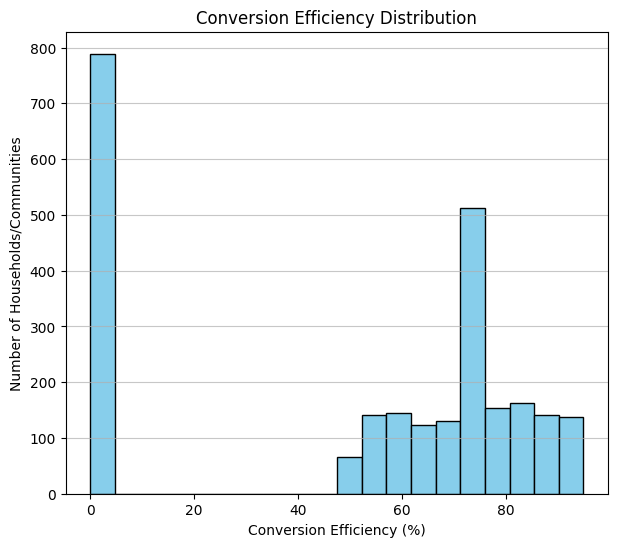

In [9]:
import matplotlib.pyplot as plt

# Drop NaN values for efficiency
efficiency_col = "Conversion_efficiency_%"
df = df.dropna(subset=[efficiency_col])

# -------------------------------------------------
# Function to plot histogram (directly shows in Colab)
# -------------------------------------------------
def plot_efficiency_histogram(bins=20):
    plt.figure(figsize=(7,6))
    plt.hist(df[efficiency_col], bins=bins, color="skyblue", edgecolor="black")
    plt.xlabel("Conversion Efficiency (%)")
    plt.ylabel("Number of Households/Communities")
    plt.title("Conversion Efficiency Distribution")
    plt.grid(axis="y", alpha=0.7)
    plt.show()


plot_efficiency_histogram(bins=20)

Anamoly Detection

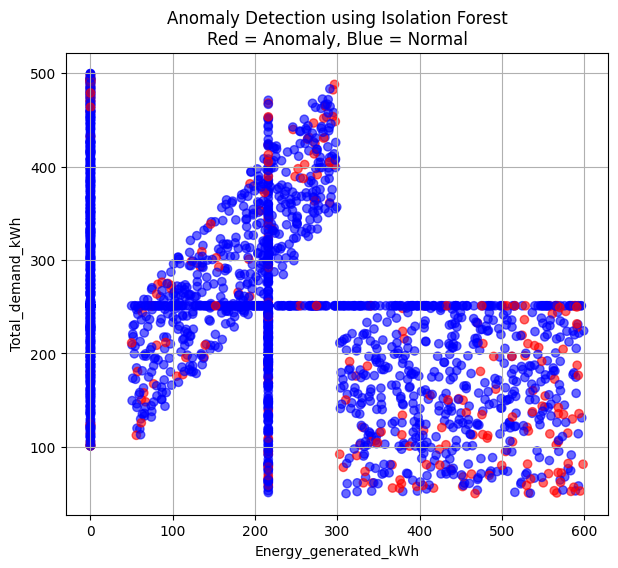

In [10]:
from sklearn.ensemble import IsolationForest

features = [
    "Energy_generated_kWh",
    "Total_demand_kWh",
    "Conversion_efficiency_%",
    "Conversion_losses_%",
    "Storage_capacity_kWh",
    "Distribution_losses_%"
]

X = df[features].fillna(0)

# -------------------------------------------------
# Train Isolation Forest
# -------------------------------------------------
model = IsolationForest(contamination=0.1, random_state=42)
df["anomaly"] = model.fit_predict(X)

# Label: -1 = anomaly, 1 = normal
df["anomaly_label"] = df["anomaly"].map({1: "Normal", -1: "Anomaly"})

# -------------------------------------------------
# Function to make scatter plot
# -------------------------------------------------
def plot_anomalies(x_axis="Energy_generated_kWh", y_axis="Total_demand_kWh"):
    plt.figure(figsize=(7,6))
    colors = df["anomaly"].map({1: "blue", -1: "red"})
    plt.scatter(df[x_axis], df[y_axis], c=colors, alpha=0.6)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(f"Anomaly Detection using Isolation Forest\nRed = Anomaly, Blue = Normal")
    plt.grid(True)
    plt.show()   # 👈 this will show the plot directly in Colab

# -------------------------------------------------
# Example Plot
# -------------------------------------------------
plot_anomalies("Energy_generated_kWh", "Total_demand_kWh")